In [1]:
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Point to insolation_model project root
insolation_root = Path(os.path.dirname(os.path.abspath(""))).resolve()
if str(insolation_root) not in sys.path:
    sys.path.insert(0, str(insolation_root))

import numpy as np

from insolation_model import vis

from insolation_model.geometry.shading import _make_wave_front, _mean_over_indices

from tests.conftest import make_dem_with_gradients

In [2]:
dx = 1
grad_x = -0.1
grad_y = -0.1
n_rows = 15
n_cols = 5
dem = make_dem_with_gradients(grad_x, grad_y, dx, dx, n_rows, n_cols)
azimuth = 25


Fi, Fj = _make_wave_front(n_rows, n_cols, azimuth)

Fi_rounded = np.round(Fi).astype(int)
Fj_rounded = np.round(Fj).astype(int)
valid_indices_on_front = (
    (Fi_rounded >= 0)
    & (Fj_rounded >= 0)
    & (Fi_rounded < n_rows)
    & (Fj_rounded < n_cols)
)

front_values = 0 * Fi - 9999
front_values[valid_indices_on_front] = dem.arr[
    Fi_rounded[valid_indices_on_front], Fj_rounded[valid_indices_on_front]
]

cummax = np.maximum.accumulate(front_values, axis=0)
shade_mask_on_front = (front_values < cummax).astype(int)


front_vector_i = Fi_rounded[valid_indices_on_front]
front_vector_j = Fj_rounded[valid_indices_on_front]
front_vector_mask = shade_mask_on_front[valid_indices_on_front]

unique_pairs, fmaskbar = _mean_over_indices(
    front_vector_i, front_vector_j, front_vector_mask
)

shade_mask = np.zeros_like(dem.arr)
shade_mask[*unique_pairs] = fmaskbar

In [3]:
def plot_indices(I, J, ax, **kwargs):
    return ax.scatter(J + 0.5, -I - 0.5, **kwargs)

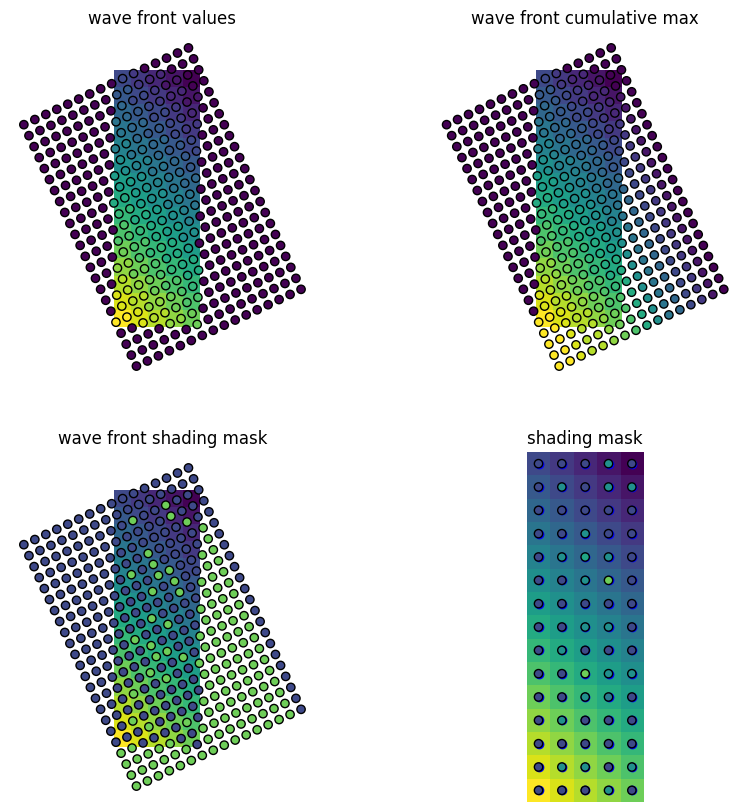

In [5]:
vmin, vmax = dem.arr.min(), dem.arr.max()

Rj, Ri = np.meshgrid(
    np.linspace(0, n_cols - 1, n_cols), np.linspace(0, n_rows - 1, n_rows)
)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for ax in axes:
    vis.raster(dem, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_axis_off()

ax = axes[0]
ax.set_title("wave front values")
plot_indices(Fi, Fj, ax, c=front_values, vmin=vmin, vmax=vmax, edgecolor="k")

ax = axes[1]
ax.set_title("wave front cumulative max")
plot_indices(Fi, Fj, ax, c=cummax, vmin=vmin, vmax=vmax, edgecolor="k")

ax = axes[2]
ax.set_title("wave front shading mask")
plot_indices(Fi, Fj, ax, c=shade_mask_on_front, vmin=vmin, vmax=vmax, edgecolor="k")

ax = axes[3]
ax.set_title("shading mask")
plot_indices(Ri, Rj, ax, color="blue")
plot_indices(Ri, Rj, ax, c=shade_mask, vmin=vmin, vmax=vmax, edgecolor="k")
plt.show()